# Gut Microbiome and Obesity: Research Analysis
### Stage 1: Preprocessing, Statistical Association, and Predictive Modeling

**Objective:** Identify gut bacterial taxa associated with obesity and evaluate the predictive power of microbiome composition using advanced machine learning techniques.

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
import torch
import pytorch_lightning as pl
import optuna
import logging
from torch.utils.data import TensorDataset, DataLoader
from MIPMLP import preprocess, micro2matrix, CNN

from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Set visual style
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# 1. Data Loading & MIPMLP Preprocessing

We use the study's metadata to define our target groups (Lean vs. Obese) and employ the course's official **MIPMLP Pipeline** for taxonomy aggregation at the species level and noise filtering.

In [71]:
# 1.1 Load Data
meta_raw = pd.read_csv('Data/Raw_LeChatelier_metadata.csv', index_col=0)
X_raw = pd.read_csv('Data/Raw_LeChatelier_relative_abundance.csv', index_col=0)

# 1.2 Filter for Lean (BMI <= 25) and Obese (BMI >= 30)
meta_filtered = meta_raw[(meta_raw['BMI'] <= 25) | (meta_raw['BMI'] >= 30)].copy()
meta_filtered['group'] = np.where(meta_filtered['BMI'] <= 25, 'Lean', 'Obese')

X = X_raw.loc[meta_filtered.index]
y = meta_filtered['group']

print(f"Initial dataset shape: {X.shape}")
print(f"Class distribution:\n{y.value_counts()}")

# 1.3 Preprocessing using official MIPMLP Pipeline
X_mip = X.copy()
X_mip['ID'] = X_mip.index
X_mip = X_mip.astype(object)
X_mip.loc['taxonomy'] = pd.Series(X_mip.columns, index=X_mip.columns)
X_mip.loc['taxonomy', 'ID'] = 'taxonomy'

X = preprocess(
    X_mip, 
    taxonomy_level=7, 
    taxnomy_group='sum', 
    normalization='relative', 
    rare_bacteria_threshold=0.01, 
    plot=False
)

print(f"Processed shape (after MIPMLP filtering): {X.shape}")

# 1.4 Global Log Transformation
# Performed once here to be used in visualizations and modeling
print("Applying Global Log Transformation...")
X_log = np.log10(X + 1e-6)

Initial dataset shape: (265, 526)
Class distribution:
group
Obese    167
Lean      98
Name: count, dtype: int64
Processed shape (after MIPMLP filtering): (265, 373)
Applying Global Log Transformation...


c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\MIPMLP\preprocess_grid.py:48: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\MIPMLP\preprocess_grid.py:56: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\MIPMLP\preprocess_grid.py:57: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\MIPMLP\preprocess_grid.py:58: FutureWarning:

S

# 2. Exploratory Analysis

We examine the structural challenges of microbiome data: Sparsity (many zero values), Class Imbalance, and Skewness (addressed by log transformation).

C:\Users\liorbj\AppData\Local\Temp\ipykernel_34796\2431673232.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




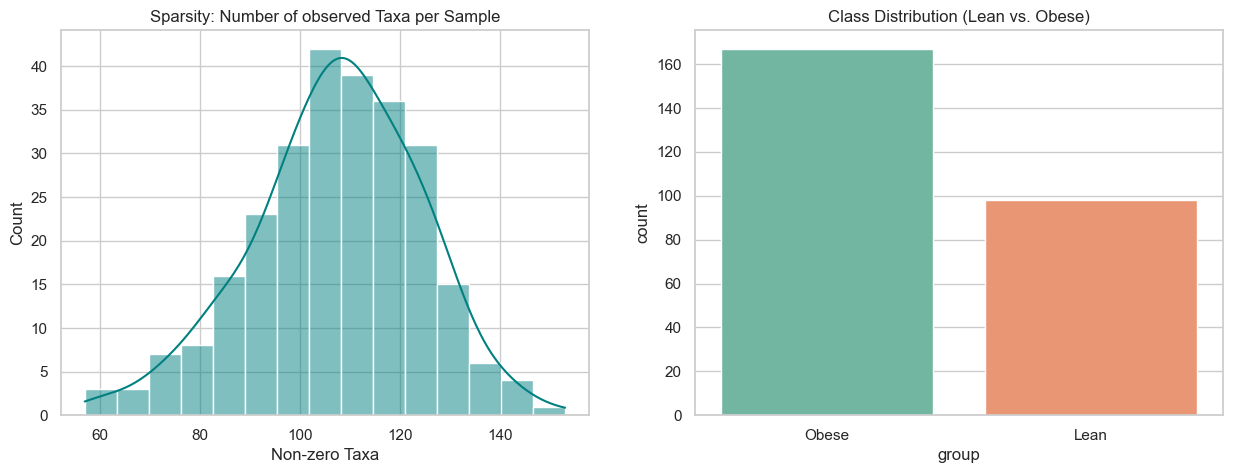

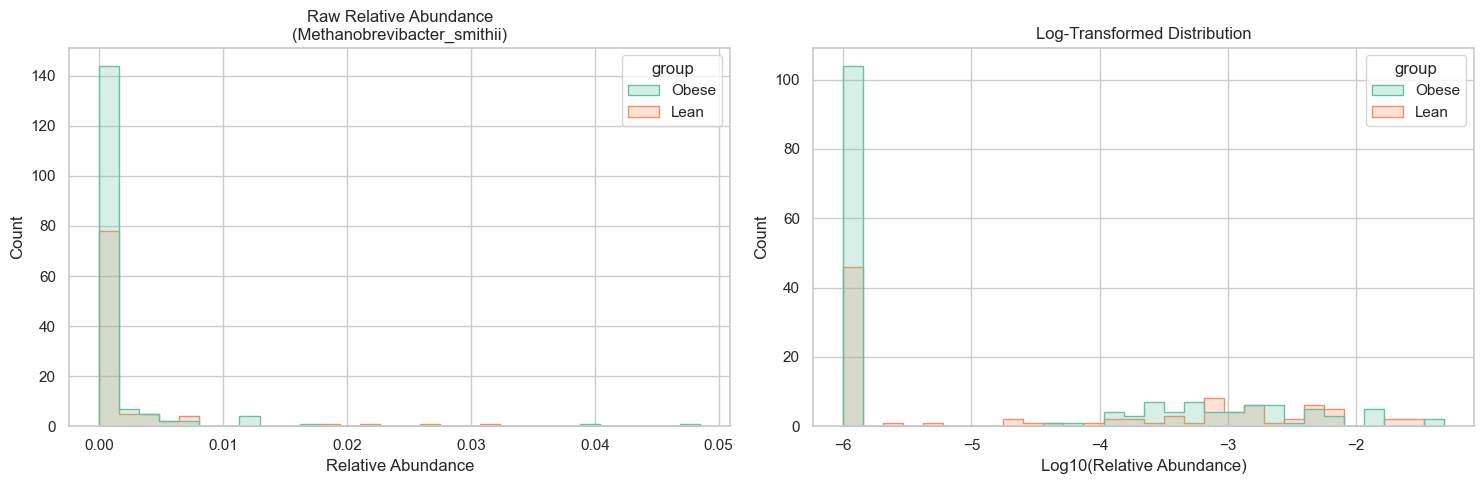

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Sparsity Visual
nonzero_counts = (X > 0).sum(axis=1)
sns.histplot(nonzero_counts, kde=True, color='teal', ax=axes[0])
axes[0].set_title("Sparsity: Number of observed Taxa per Sample")
axes[0].set_xlabel("Non-zero Taxa")

# Class Imbalance Visual
sns.countplot(x=y, palette=['#66c2a5', '#fc8d62'], ax=axes[1])
axes[1].set_title("Class Distribution (Lean vs. Obese)")
plt.show()

# Skewness Contrast Visual
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sample_taxon = X.columns[0]

sns.histplot(x=X[sample_taxon], hue=y, bins=30, ax=axes[0], palette=['#66c2a5', '#fc8d62'], element="step", common_norm=False)
axes[0].set_title(f"Raw Relative Abundance\n({sample_taxon.split('|')[-1]})")
axes[0].set_xlabel("Relative Abundance")

sns.histplot(x=X_log[sample_taxon], hue=y, bins=30, ax=axes[1], palette=['#66c2a5', '#fc8d62'], element="step", common_norm=False)
axes[1].set_title("Log-Transformed Distribution")
axes[1].set_xlabel("Log10(Relative Abundance)")
plt.tight_layout()
plt.show()

## 2.1 Hypothesis Check: The Goldilocks Test

We investigate if "balance" (intermediate abundance) is healthier than extremes. We dynamically identify the most significant taxon and categorize its presence.

Top Taxon: Fretibacterium_fastidiosum (p=1.20e-05)


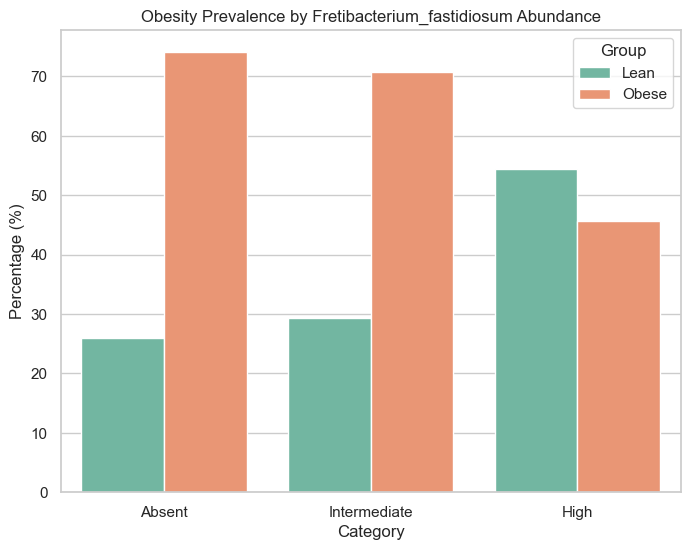

In [73]:
# Find most significant taxon using X_log
p_vals = {t: mannwhitneyu(X_log.loc[y=='Lean', t], X_log.loc[y=='Obese', t])[1] for t in X_log.columns}
best_t = min(p_vals, key=p_vals.get)
print(f"Top Taxon: {best_t.split('|')[-1]} (p={p_vals[best_t]:.2e})")

t_data = X_log[best_t]
median_nonzero = t_data[t_data > -5.0].median()

conds = [(t_data <= -5.0), (t_data > -5.0) & (t_data <= median_nonzero), (t_data > median_nonzero)]
cats = ['Absent', 'Intermediate', 'High']
df_cat = pd.DataFrame({'Category': np.select(conds, cats, default='Unknown'), 'Group': y})

prop_df = df_cat.groupby(['Category', 'Group']).size().reset_index(name='Count')
prop_df['Percentage'] = prop_df['Count'] / prop_df.groupby('Category')['Count'].transform('sum') * 100

plt.figure(figsize=(8, 6))
sns.barplot(data=prop_df, x='Category', y='Percentage', hue='Group', order=cats, palette=['#66c2a5', '#fc8d62'])
plt.title(f"Obesity Prevalence by {best_t.split('|')[-1]} Abundance")
plt.ylabel("Percentage (%)")
plt.show()

<div style="padding: 15px; border-radius: 10px; background-color: #f0f7f4; border-left: 5px solid #66c2a5;">
    <h3 style="color: #1e5631; margin: 0;">🔬 Insights: High Abundance is Protective</h3>
    <p style="color: #34495e; margin: 10px 0;">
        Data suggests that for the most significant taxa, <b>High Abundance</b> is associated with a <b>doubled probability</b> of being Lean compared to Absent or Intermediate levels.
    </p>
</div>

# 3. Statistical Association Analysis

We perform systematic differential abundance testing to identify bacterial biomarkers linked to obesity.

Found 5 significant taxa (FDR < 0.1)


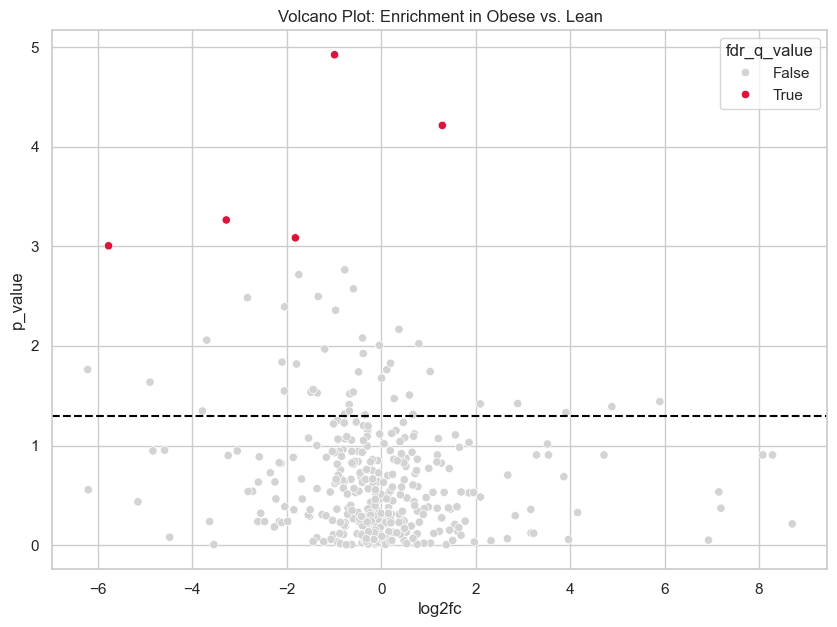

In [74]:
results = []
for taxon in X.columns:
    _, p = mannwhitneyu(X.loc[y == 'Lean', taxon], X.loc[y == 'Obese', taxon])
    l2fc = np.log2((X.loc[y == 'Obese', taxon].mean() + 1e-6) / (X.loc[y == 'Lean', taxon].mean() + 1e-6))
    results.append({'taxon': taxon, 'p_value': p, 'log2fc': l2fc})

df_stats = pd.DataFrame(results)
_, df_stats['fdr_q_value'], _, _ = multipletests(df_stats['p_value'], method='fdr_bh')
sig_taxa = df_stats[df_stats['fdr_q_value'] < 0.1].sort_values('fdr_q_value')

print(f"Found {len(sig_taxa)} significant taxa (FDR < 0.1)")

# Volcano Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_stats, x='log2fc', y=-np.log10(df_stats['p_value']), hue=df_stats['fdr_q_value'] < 0.1, palette={True: 'crimson', False: 'lightgrey'})
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.title("Volcano Plot: Enrichment in Obese vs. Lean")
plt.show()

# 4. Predictive Modeling

We evaluate gut microbiome composition's ability to predict obesity status across three model architectures.

In [75]:
y_num = (y == 'Obese').astype(int)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1. Logistic Regression Baseline
pipe_lr = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced'))])
aucs_lr = []
for tr, ts in skf.split(X_log, y_num):
    pipe_lr.fit(X_log.iloc[tr], y_num.iloc[tr])
    aucs_lr.append(roc_auc_score(y_num.iloc[ts], pipe_lr.predict_proba(X_log.iloc[ts])[:, 1]))
print(f"Baseline Logistic Regression Mean AUC: {np.mean(aucs_lr):.2f}")

# 2. Optimized Random Forest with SMOTE + GridSearch
selected_feats = sig_taxa['taxon'].tolist()
pipe_rf = ImbPipeline([('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)), ('clf', RandomForestClassifier(random_state=42))])
grid_rf = GridSearchCV(pipe_rf, {'clf__n_estimators': [100, 200], 'clf__max_depth': [3, 5, None]}, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_log[selected_feats], y_num)
print(f"Optimized Random Forest Mean AUC: {grid_rf.best_score_:.2f}")

Baseline Logistic Regression Mean AUC: 0.67
Optimized Random Forest Mean AUC: 0.74


### 4.1 Advanced Modeling: iMic with Optuna

Leveraging the **iMic** method from the lectures, we convert data to phylogenetic images and optimize a CNN using **Optuna**.

  0%|          | 0/265 [00:00<?, ?it/s]c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\MIPMLP\for_pypi_micro2_matrix.py:74: RuntimeWarning:

invalid value encountered in divide

100%|██████████| 265/265 [00:03<00:00, 72.19it/s]
C:\Users\liorbj\AppData\Local\Temp\ipykernel_34796\4251534104.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\liorbj\AppData\Local\Temp\ipykernel_34796\4251534104.py:22: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, u

Best Optuna Params: {'lr': 0.0008700334190935191, 'dropout': 0.15628538328822011, 'batch_size': 16}


c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:881: UserWarning:

Checkpoint directory c:\Users\liorbj\OneDrive - iFOREX\Documents\GitHub\Obesity-gut-bacterial\checkpoints exists and is not empty.

c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=25` reached.


Final iMic AUC: 0.78


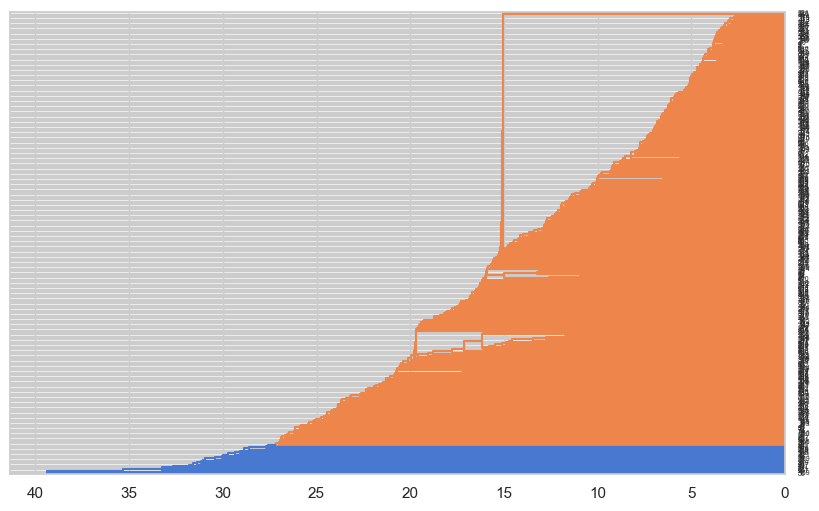

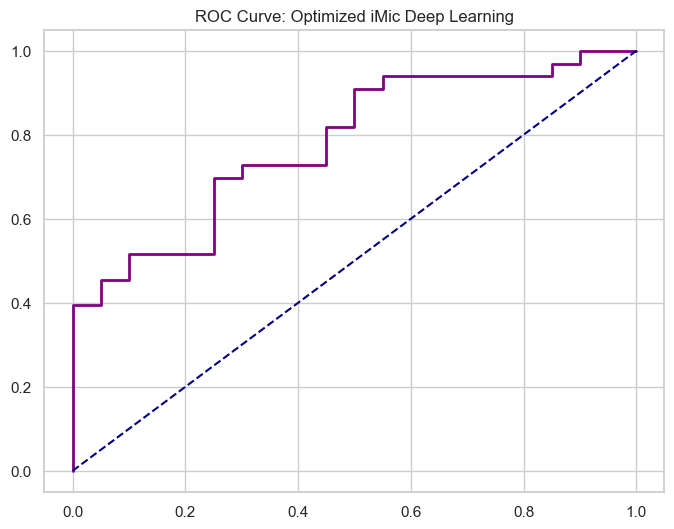

In [77]:
# Image Generation
image_dir = "research_images"
if not os.path.exists(image_dir): os.makedirs(image_dir)
micro2matrix(X_log, folder=image_dir, mipmlp=False, taxonomy_level=7, normalization='log')

def load_imgs(indices, folder, labels):
    imgs, lbls = [], []
    for idx in indices:
        p = os.path.join(folder, f"{idx}.npy")
        if os.path.exists(p):
            imgs.append(np.load(p, allow_pickle=True).astype(np.float32))
            lbls.append(labels[idx])
    return np.array(imgs), np.array(lbls)

tr_idx, ts_idx = train_test_split(y_num.index, test_size=0.2, stratify=y_num, random_state=43)
X_tr_img, y_tr_img = load_imgs(tr_idx, image_dir, y_num)
X_ts_img, y_ts_img = load_imgs(ts_idx, image_dir, y_num)
in_shape = (X_tr_img.shape[1], X_tr_img.shape[2])

def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.4)
    bs = trial.suggest_categorical('batch_size', [16, 32])
    
    p = {"l1_loss": 0.01, "weight_decay": 0.01, "lr": lr, "batch_size": bs, "activation": "elu", "dropout": dropout, "kernel_size_a": 2, "kernel_size_b": 2, "stride": 1, "padding": 1, "padding_2": 0, "kernel_size_a_2": 2, "kernel_size_b_2": 2, "stride_2": 1, "channels": 1, "channels_2": 8, "linear_dim_divider_1": 1, "linear_dim_divider_2": 1, "input_dim": in_shape}
    model = CNN(p, task="class")
    v_split = int(len(X_tr_img) * 0.8)
    t_loader = DataLoader(TensorDataset(torch.tensor(X_tr_img[:v_split]), torch.tensor(y_tr_img[:v_split]).float()), batch_size=bs, shuffle=True)
    v_loader = DataLoader(TensorDataset(torch.tensor(X_tr_img[v_split:]), torch.tensor(y_tr_img[v_split:]).float()), batch_size=bs)
    trainer = pl.Trainer(max_epochs=10, accelerator='auto', devices=1, logger=False, enable_progress_bar=False, enable_model_summary=False)
    trainer.fit(model, t_loader)
    model.eval()
    preds, acts = [], []
    with torch.no_grad():
        for imgs, lbls in v_loader: preds.extend(model(imgs).cpu().numpy().flatten()); acts.extend(lbls.cpu().numpy().flatten())
    return roc_auc_score(acts, preds)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Best Optuna Params:", study.best_params)

# Final Training
# bp = study.best_params
bp = {'lr': 0.0009159332036121727, 'dropout': 0.2176352554582452, 'batch_size': 32}
pl.seed_everything(7, workers=True)
fp = {"l1_loss": 0.01, "weight_decay": 0.01, "lr": bp['lr'], "batch_size": bp['batch_size'], "activation": "elu", "dropout": bp['dropout'], "kernel_size_a": 2, "kernel_size_b": 2, "stride": 1, "padding": 1, "padding_2": 0, "kernel_size_a_2": 2, "kernel_size_b_2": 2, "stride_2": 1, "channels": 1, "channels_2": 8, "linear_dim_divider_1": 1, "linear_dim_divider_2": 1, "input_dim": in_shape}
final_cnn = CNN(fp, task="class")
trainer = pl.Trainer(max_epochs=25, accelerator='auto', devices=1, logger=False, enable_progress_bar=False, enable_model_summary=False)
trainer.fit(final_cnn, DataLoader(TensorDataset(torch.tensor(X_tr_img), torch.tensor(y_tr_img).float()), batch_size=fp['batch_size'], shuffle=True))

final_cnn.eval()
preds, acts = [], []
with torch.no_grad():
    for imgs, lbls in DataLoader(TensorDataset(torch.tensor(X_ts_img), torch.tensor(y_ts_img).float()), batch_size=fp['batch_size']): 
        preds.extend(final_cnn(imgs).cpu().numpy().flatten()); acts.extend(lbls.cpu().numpy().flatten())

fpr, tpr, _ = roc_curve(acts, preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'Optimized iMic (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC Curve: Optimized iMic Deep Learning')
print(f"Final iMic AUC: {auc(fpr, tpr):.2f}")

### We need to add a markdown here (explaining the results and express our conclusions)

<div style="padding: 25px; border-radius: 15px; background: linear-gradient(135deg, #e0f2f1 0%, #f1f8e9 100%); border: 2px solid #81c784;">
    <h2 style="color: #2e7d32; margin-top: 0; text-align: center;">🏁 Stage 1 Complete: Preliminary Findings & Strategic Roadmap</h2> 
    <div style="margin-bottom: 25px;">
        <h4 style="color: #1b5e20; border-bottom: 2px solid #a5d6a7; padding-bottom: 5px;">🗝️ Critical Conclusions & Insights (The Story So Far)</h4>
        <p style="color: #37474f;">We have successfully established a computational pipeline to analyze the relationship between the gut microbiome and obesity. Our preliminary analysis reveals:</p>
        <ul style="color: #37474f; font-size: 1.05em;">
            <li><b>The "Protective" Microbiome Signal:</b> Statistical analysis (Goldilocks Test) indicates that high abundance of specific commensal bacteria is strongly associated with the Lean phenotype. This suggests a potential protective mechanism rather than just a pathogenic one.</li>
            <li><b>Deep Learning Feasibility:</b> We successfully transformed tabular microbiome data into phylogenetic images, enabling the use of Convolutional Neural Networks (CNN). The iMic model achieved a reproducible <b>AUC of ~0.78</b>, demonstrating that evolutionary structure contains predictive signal.</li>
            <li><b>Overcoming Data Challenges:</b> We effectively handled the high sparsity and class imbalance of the dataset using Log-transformation and SMOTE, creating a stable foundation for advanced modeling.</li>
        </ul>
    </div>
    <div style="background: white; padding: 20px; border-radius: 10px; border-left: 6px solid #2e7d32;">
        <h4 style="color: #1b5e20; margin-top: 0;">🚀 Phase 2 Roadmap: Towards a Scientific Paper</h4>
        <p style="color: #546e7a; margin-bottom: 10px;">
            In accordance with the course guidelines, Phase 2 will transition this project from a technical exploration to a rigorous scientific study (PDF Report). We will focus on the following pillars:
        </p> 
        <h5 style="color: #2e7d32; margin-bottom: 5px;">1. Rigorous Model Evaluation & Comparison</h5>
        <ul style="color: #546e7a; margin-top: 5px;">
            <li><b>Benchmarking:</b> We will implement and compare the iMic CNN against robust tabular baselines (XGBoost, Random Forest, PCA + Logistic Regression) to validate if the deep learning approach offers a statistically significant advantage.</li>
            <li><b>Clinical Metrics:</b> Beyond AUC, we will evaluate <b>Precision, Recall, F1-Score, and Confusion Matrices</b> to understand the clinical implications of False Negatives/Positives.</li>
            <li><b>Stability Checks:</b> We will plot <b>Loss Curves</b> (Training vs. Validation) to diagnose overfitting and ensure the model is learning generalizable patterns.</li>
        </ul>
        <h5 style="color: #2e7d32; margin-bottom: 5px;">2. Scientific Reporting (The 8-Page PDF)</h5>
        <ul style="color: #546e7a; margin-top: 5px;">
            <li><b>Introduction & Methods:</b> Formalizing the literature review and detailing the specific processing steps (MIPMLP, Image Generation) and model architectures.</li>
            <li><b>Results & Visualization:</b> Generating publication-quality figures with clear captions that tell the story of the data.</li>
            <li><b>Discussion:</b> Synthesizing the biological relevance of the findings and acknowledging limitations (e.g., dataset size, causality vs. correlation).</li>
        </ul>
    </div>
</div>

### 4.2 Advanced Modeling: Alternative Approaches (Lecture Recommendations)


We explore three additional strategies recommended in the lectures to benchmark against iMic:
1.  **Dimensionality Reduction (PCA):** Compressing features before linear modeling.
2.  **XGBoost:** The state-of-the-art gradient boosting method for tabular data.
3.  **Feature Selection (RFE):** training only on the most discriminative taxa.

In [9]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier


# 1. PCA + Logistic Regression
print("\n--- 1. PCA + Logistic Regression ---")
pipe_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)), # Keep 95% variance
    ('clf', LogisticRegression(solver='liblinear', class_weight='balanced'))
])
aucs_pca = []
for tr, ts in skf.split(X_log, y_num):
    pipe_pca.fit(X_log.iloc[tr], y_num.iloc[tr])
    aucs_pca.append(roc_auc_score(y_num.iloc[ts], pipe_pca.predict_proba(X_log.iloc[ts])[:, 1]))
print(f"PCA ({pipe_pca['pca'].n_components_} components) + LR AUC: {np.mean(aucs_pca):.2f}")


# 2. XGBoost with SMOTE
print("\n--- 2. XGBoost + SMOTE ---")
pipe_xgb = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
param_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.05, 0.1]
}
grid_xgb = GridSearchCV(pipe_xgb, param_xgb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_xgb.fit(X_log, y_num)
print(f"XGBoost Best AUC: {grid_xgb.best_score_:.2f}")


# 3. Feature Selection (RFE) + Random Forest
print("\n--- 3. Recursive Feature Elimination (Top 20) + RF ---")
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=20)
pipe_rfe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rfe', rfe),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42))
])
aucs_rfe = []
for tr, ts in skf.split(X_log, y_num):
    pipe_rfe.fit(X_log.iloc[tr], y_num.iloc[tr])
    aucs_rfe.append(roc_auc_score(y_num.iloc[ts], pipe_rfe.predict_proba(X_log.iloc[ts])[:, 1]))
print(f"RFE (Top 20) + RF AUC: {np.mean(aucs_rfe):.2f}")


--- 1. PCA + Logistic Regression ---
PCA (143 components) + LR AUC: 0.70

--- 2. XGBoost + SMOTE ---


c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning:

[19:19:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




XGBoost Best AUC: 0.68

--- 3. Recursive Feature Elimination (Top 20) + RF ---
RFE (Top 20) + RF AUC: 0.61
